In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from state_cleaner import *
import datetime
from scipy import stats as st

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
os.chdir('../..')
os.chdir('CovidMobile')
os.getcwd()

'/Users/samismalling/Documents/mobility-report-data-extractor-master/CovidMobile'

In [3]:
df = pd.read_csv('data/compiled_2020-04-21.csv')

In [4]:
df['peaks'] = df.groupby(['FIPS'])['cases'].transform(max)

In [5]:
df.rename(columns={'state_x':'state','county_x':'county'},inplace=True)

In [6]:
df['post_soe'] = np.where(df['date']>=df['soe'],1,0)
df['post_sah'] = np.where(df['date']>=df['sah'],1,0)

In [7]:
def t_test(pop,div,metric):
    data = pop.dropna(subset=[metric])
    s1 = data[data[div]==1][metric].copy()
    s2 = data[data[div]==0][metric].copy()
    print('What happend at {}?'.format(metric))
    print(data.groupby([div])[metric].describe())
    print("\n T-Test Results = {} (t-stat,2 sided p-values)".format(st.ttest_ind(s1,s2)))

In [8]:
for i in ['retail','food_drugs','park','transit','work','homes']:
    t_test(df,'post_soe',i)
    t_test(df,'post_sah',i)

What happend at retail?
            count       mean        std    min   25%   50%   75%    max
post_soe                                                               
0         58686.0   8.300770  11.339559  -85.0   2.0   8.0  14.0  153.0
1         74764.0 -24.533893  21.916760 -100.0 -40.0 -29.0  -9.0  226.0

 T-Test Results = Ttest_indResult(statistic=-329.9193674842295, pvalue=0.0) (t-stat,2 sided p-values)
What happend at retail?
             count       mean        std    min   25%   50%   75%    max
post_sah                                                                
0         108743.0  -3.157932  20.766688 -100.0 -17.0   3.0  11.0  226.0
1          24707.0 -40.624519  12.316418 -100.0 -48.0 -40.0 -33.0   60.0

 T-Test Results = Ttest_indResult(statistic=-272.89177542159325, pvalue=0.0) (t-stat,2 sided p-values)
What happend at food_drugs?
            count      mean        std   min   25%  50%   75%    max
post_soe                                                            

In [9]:
prez = pd.read_csv("data/countypres_2000-2016.csv")

In [10]:
prez.head()

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
0,2000,Alabama,AL,Autauga,1001.0,President,Al Gore,democrat,4942.0,17208,20191203
1,2000,Alabama,AL,Autauga,1001.0,President,George W. Bush,republican,11993.0,17208,20191203
2,2000,Alabama,AL,Autauga,1001.0,President,Ralph Nader,green,160.0,17208,20191203
3,2000,Alabama,AL,Autauga,1001.0,President,Other,NaN,113.0,17208,20191203
4,2000,Alabama,AL,Baldwin,1003.0,President,Al Gore,democrat,13997.0,56480,20191203


In [11]:
prez['vote_share']= prez['candidatevotes'] / prez['totalvotes']
prez['vote_share'].describe()

count    50120.000000
mean         0.314603
std          0.264512
min          0.000000
25%          0.022464
50%          0.327248
75%          0.539318
max          0.960334
Name: vote_share, dtype: float64

In [12]:
prez['max'] = prez.groupby(['FIPS','year'])['candidatevotes'].transform(max)
prez_win = prez[prez['max']==prez['candidatevotes']].copy()

In [13]:
prez_win.sort_values(by=['FIPS','year'],inplace=True)
for i in list(range(1,5,1)):
    shifted =prez_win.groupby(['FIPS'])['candidate','party','candidatevotes','totalvotes'].shift(i)
    prez_win = prez_win.join(shifted.rename(columns=lambda x: x+"_{}".format(i)))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
prez_win = prez_win[prez_win['party_4'].notnull()].copy() 

In [15]:
prez_win.columns

Index(['year', 'state', 'state_po', 'county', 'FIPS', 'office', 'candidate',
       'party', 'candidatevotes', 'totalvotes', 'version', 'vote_share', 'max',
       'candidate_1', 'party_1', 'candidatevotes_1', 'totalvotes_1',
       'candidate_2', 'party_2', 'candidatevotes_2', 'totalvotes_2',
       'candidate_3', 'party_3', 'candidatevotes_3', 'totalvotes_3',
       'candidate_4', 'party_4', 'candidatevotes_4', 'totalvotes_4'],
      dtype='object')

In [16]:
conditions = [
    (prez_win['party']=='republican')&((prez_win['party_1']=='democrat')|(prez_win['party_2']=='democrat')),
    (prez_win['party']=='republican')&(prez_win['party_1']=='republican')&(prez_win['party_2']=='republican'),
    (prez_win['party']=='democrat')&(prez_win['party_1']=='democrat')&(prez_win['party_2']=='democrat'),
    (prez_win['party']=='democrat')&((prez_win['party_1']=='republican')|(prez_win['party_2']=='republican')),
]
vals =['flip_trump','stay_trump','stay_hill','flip_hill']


In [17]:
prez_win['results'] =  np.select(conditions, vals, default='miss')

In [18]:
df_tog = df.merge(prez_win,on=['FIPS'],how='left')

In [19]:
grp_1 = pd.melt(df_tog, id_vars=['FIPS', 'date'], value_vars=['retail','food_drugs','park','transit','work','homes']) 
grp_1.dropna(inplace=True)
grp_1[['FIPS', 'date']].drop_duplicates().shape

(154946, 2)

In [20]:
grp_2 = pd.melt(df_tog, id_vars=['FIPS', 'date','candidate'], value_vars=['retail','food_drugs','park','transit','work','homes']) 
grp_2.dropna(inplace=True)
grp_2[['FIPS', 'date']].drop_duplicates().shape

(151492, 2)

In [21]:
grp_3 = pd.melt(df_tog, id_vars=['FIPS', 'date','results'], value_vars=['retail','food_drugs','park','transit','work','homes']) 
grp_3.dropna(inplace=True)
grp_3[['FIPS', 'date']].drop_duplicates().shape

(151492, 2)

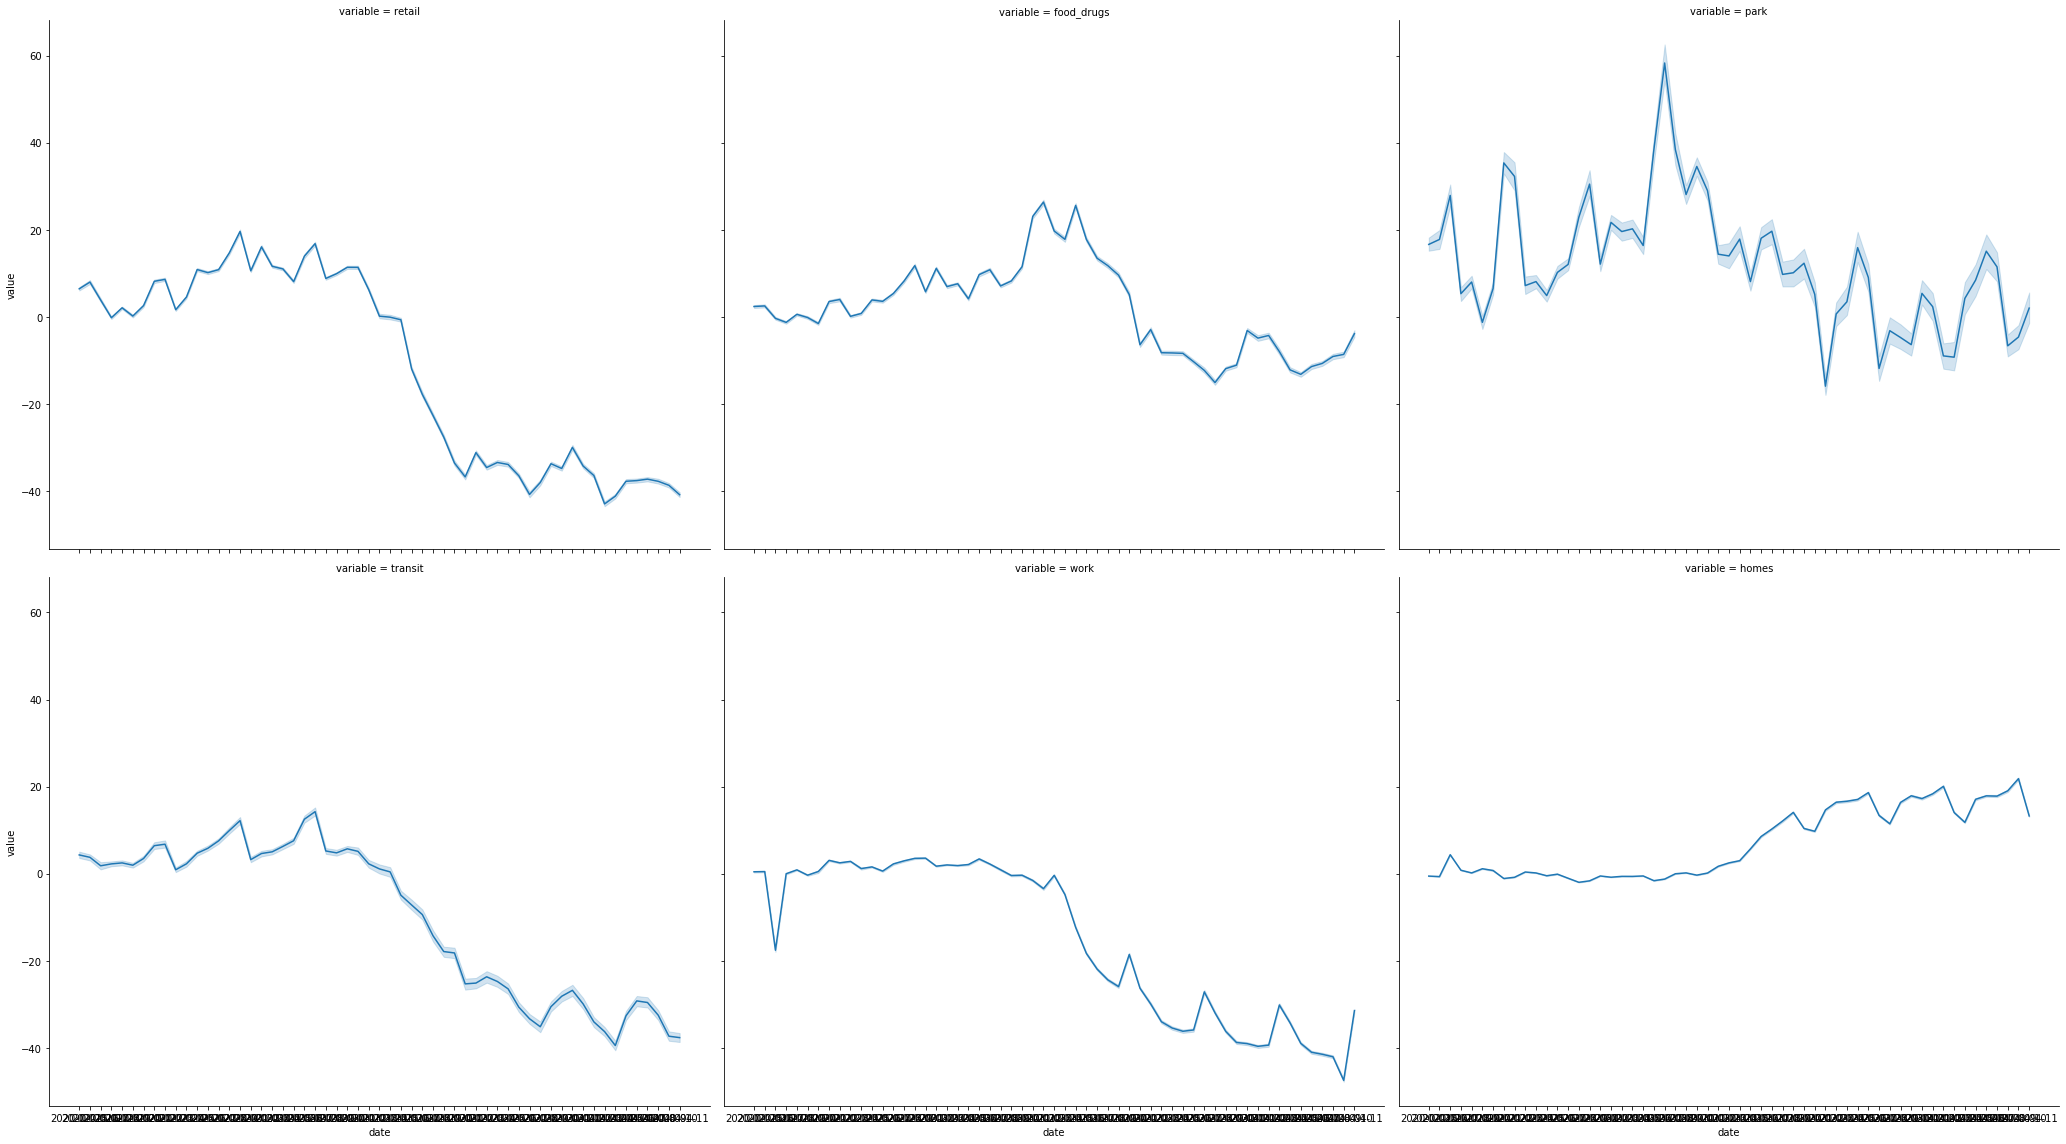

In [22]:
g = sns.relplot(x="date", y="value",
                 col="variable",
                 kind="line", data=grp_1,height=8, aspect=1.2,col_wrap=3)

plt.savefig('graphs/mobility_by_county_overall.png')

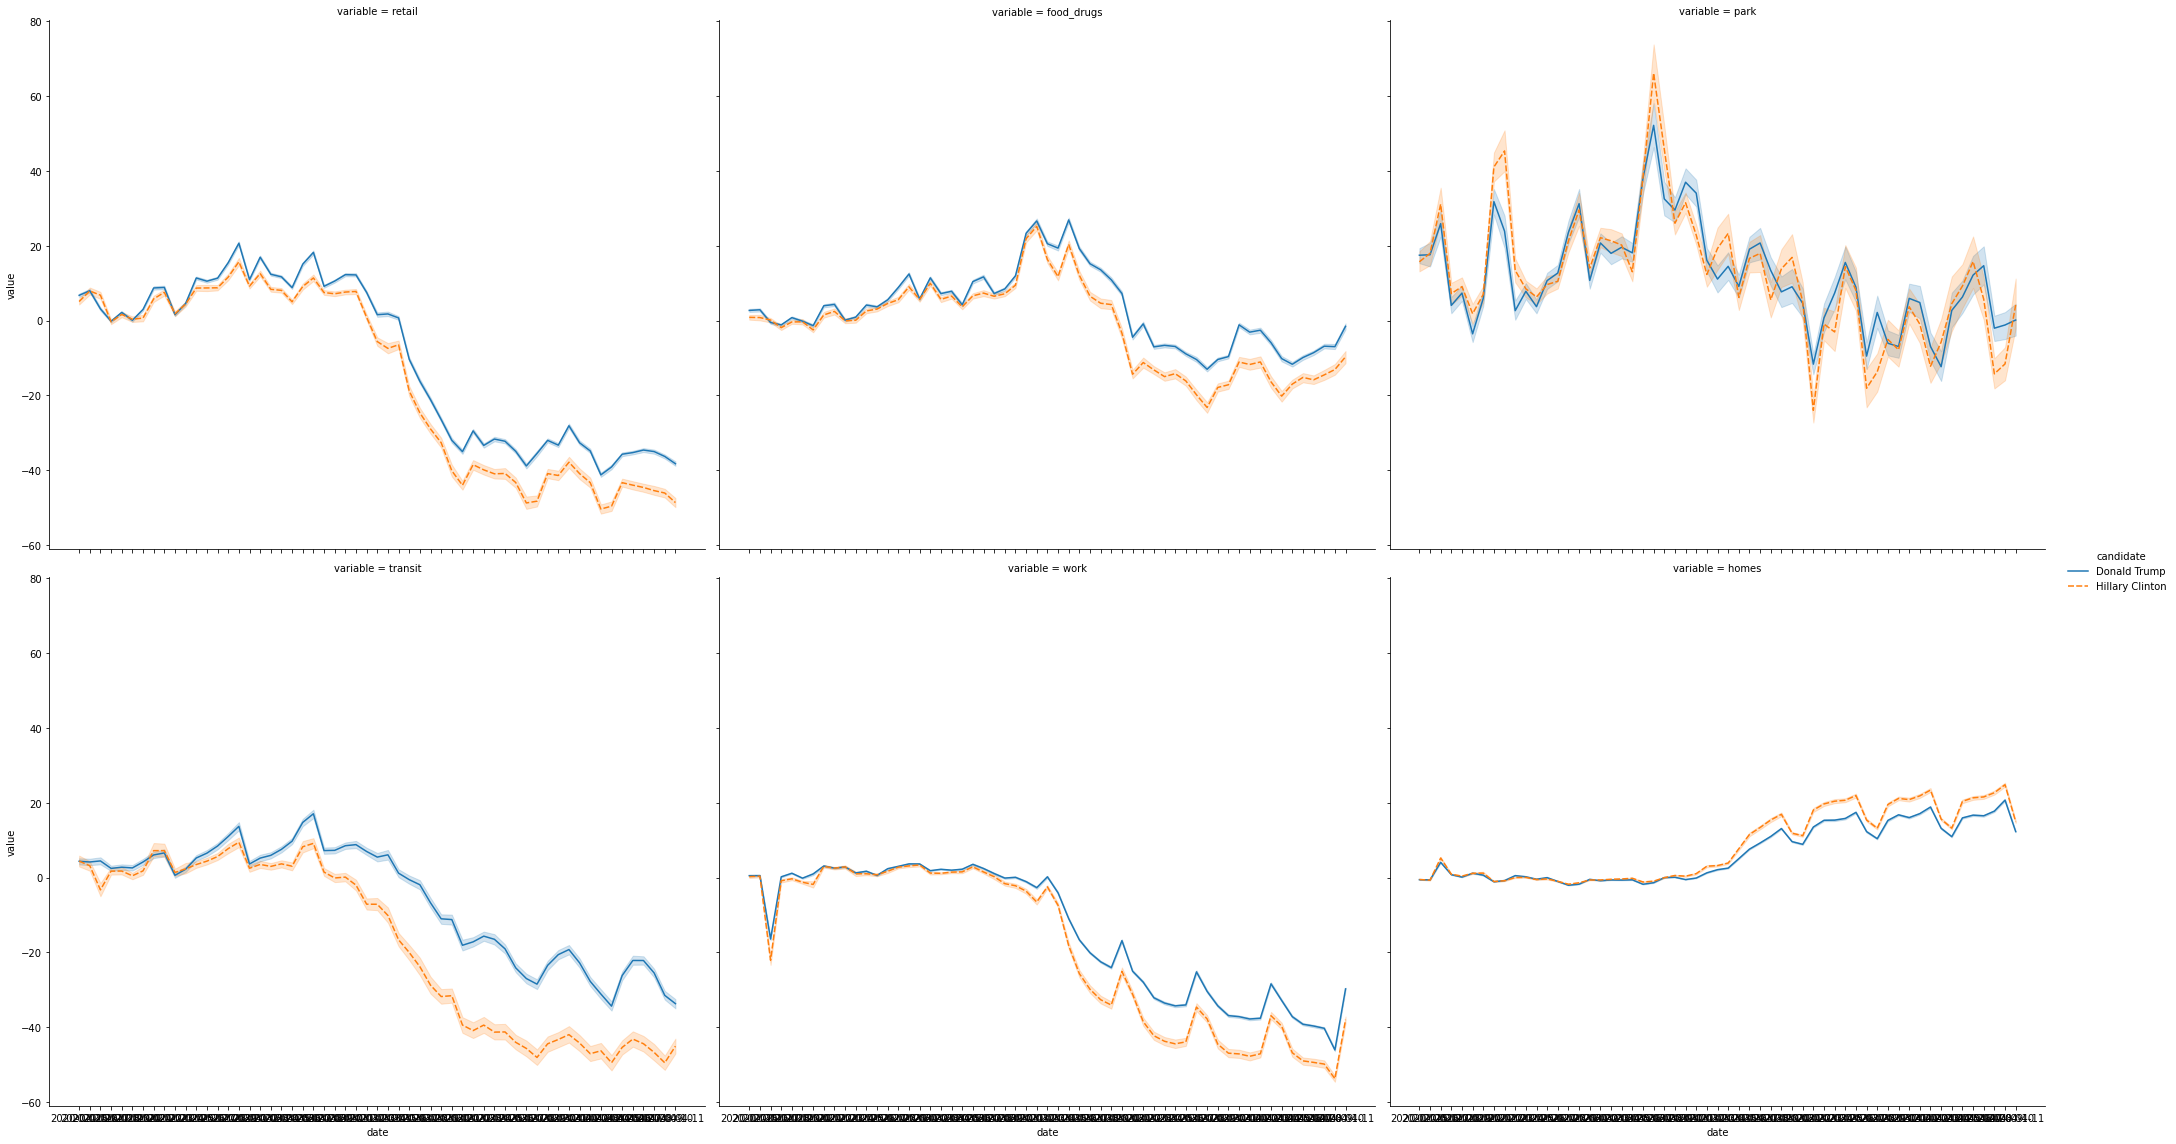

In [91]:
g = sns.relplot(x="date", y="value",
                 col="variable", hue="candidate", style="candidate",
                 kind="line", data=grp_2,height=8, aspect=1.2,col_wrap=3)

plt.savefig('graphs/mobility_by_county_voting_2016.png')

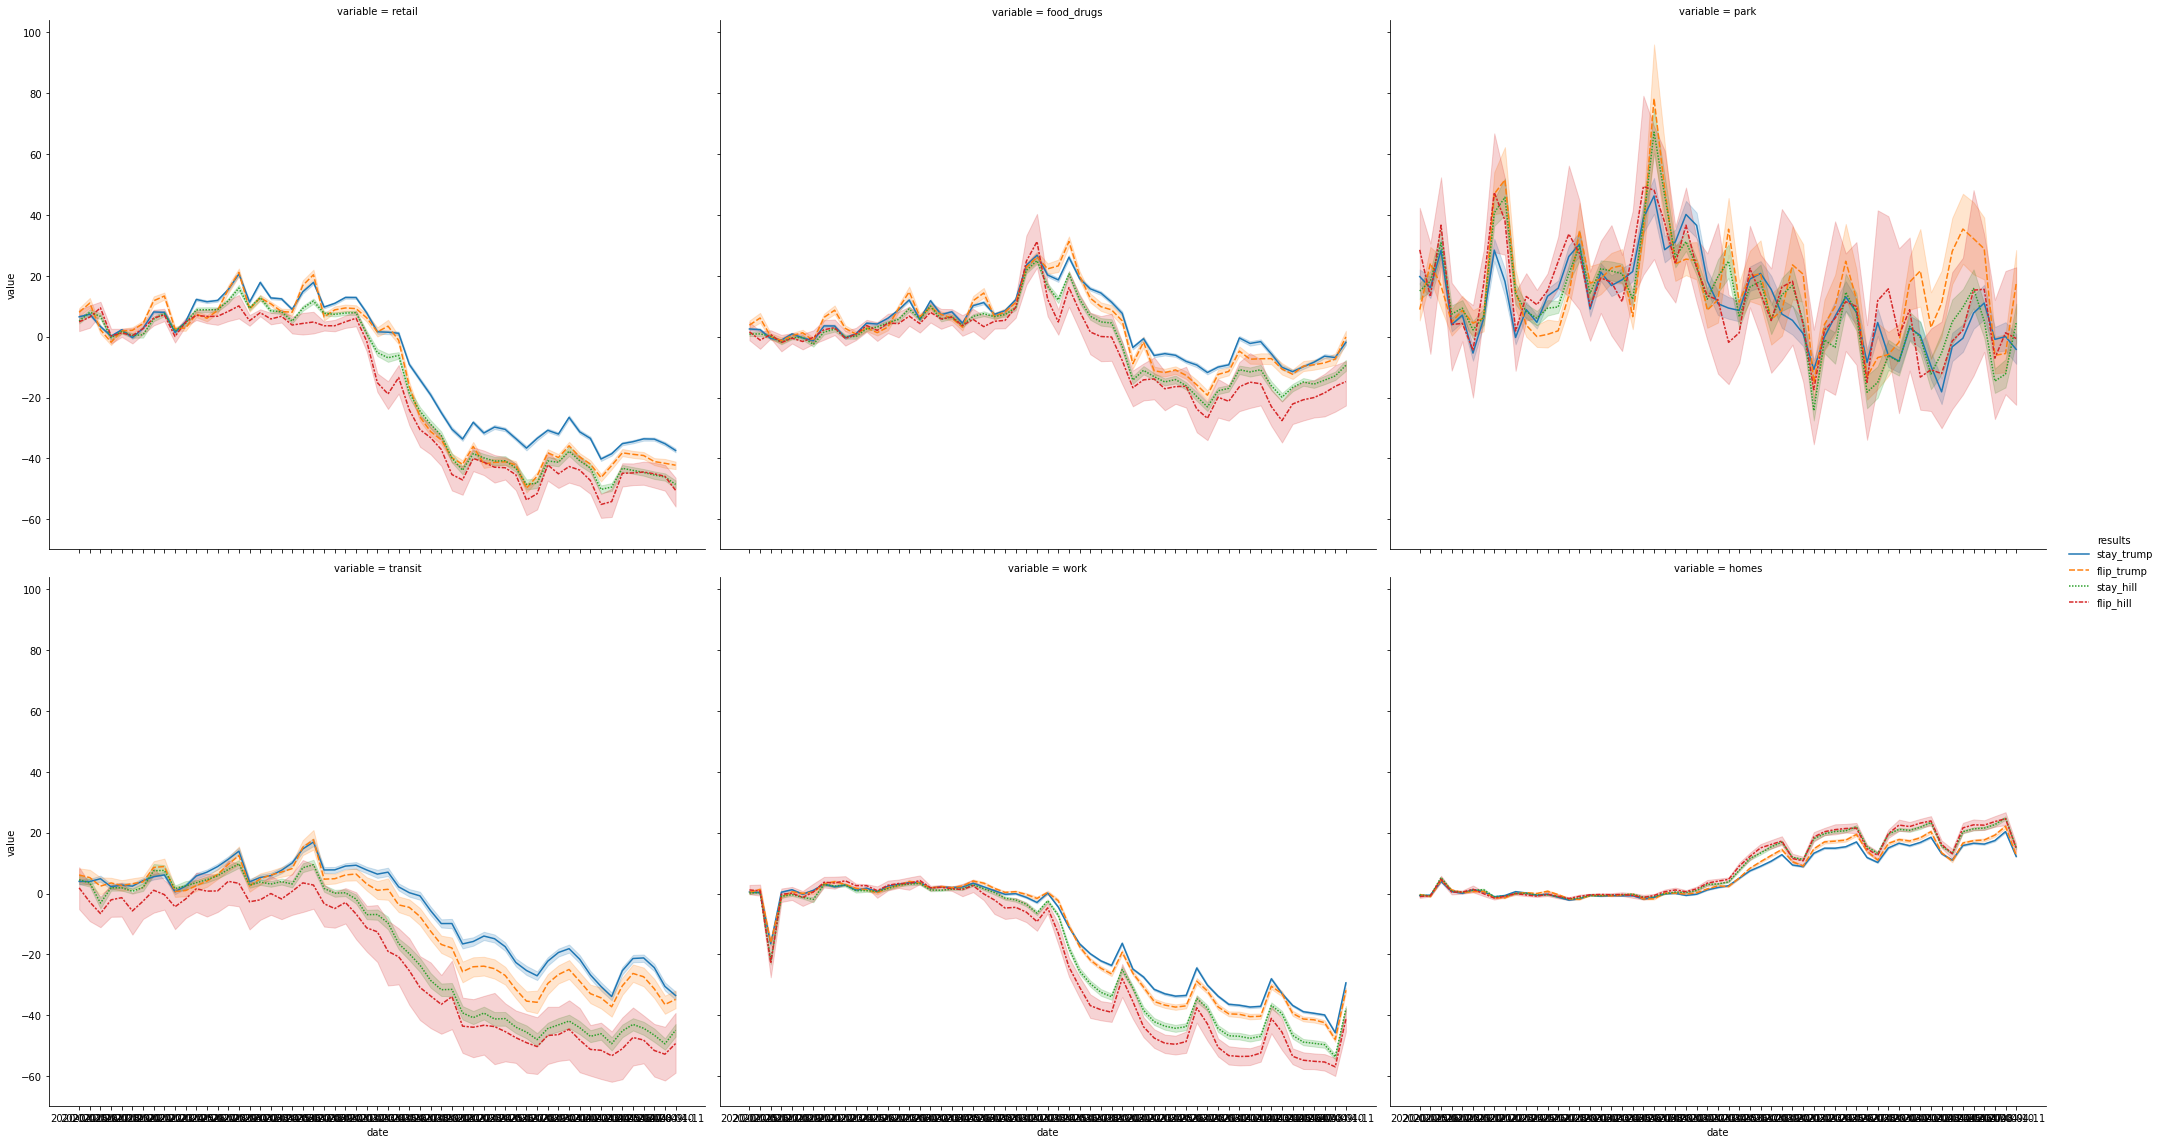

In [92]:
g = sns.relplot(x="date", y="value",
                 col="variable", hue="results", style="results",
                 kind="line", data=grp_3,height=8, aspect=1.2,col_wrap=3)

plt.savefig('graphs/mobility_by_county_voting_history.png')

In [28]:
#Now working through the USDA data to get population data:
usda_full = pd.read_excel('./data/food_env_atlas_usda.xls', sheet_name = None)
sheet_names = usda_full.keys()
for sheet_name in usda_full.keys():
    print(sheet_name)

Read_Me
Variable List
Supplemental Data - County
Supplemental Data - State
ACCESS
STORES
RESTAURANTS
ASSISTANCE
INSECURITY
PRICES_TAXES
LOCAL
HEALTH
SOCIOECONOMIC


In [57]:
usda_pop = usda_full['Supplemental Data - County']
usda_pop.head()
usda_pop.describe()

,FIPS
count,3142.000000
mean,30383.649268
std,15162.508374
min,1001.000000
25%,18177.500000
50%,29176.000000
75%,45080.500000
max,56045.000000


In [63]:
usda_pop['FIPS ']

0        1001
1        1003
2        1005
3        1007
4        1009
        ...  
3137    56037
3138    56039
3139    56041
3140    56043
3141    56045
Name: FIPS , Length: 3142, dtype: int64

In [66]:
print(usda_stores['FIPS'][34])

1069


In [86]:
list1 = set(usda_stores['FIPS']) 
list2 = set(usda_pop['FIPS '])
print(list(set(list2).difference(list1)))

#46102 in usda_stores['FIPS']
46102 in usda_pop['FIPS ']

[2158, 46102]


False

In [53]:
usda_stores = usda_full['STORES']
#includes grocery stores, "supercenters", convenience stores, and specialized food stores
groc_stores14 = usda_stores[['FIPS', 'GROC14','SUPERC14','CONVS14','SPECS14',]] 
total = groc_stores14['GROC14']+ groc_stores14['SUPERC14']+groc_stores14['CONVS14']+groc_stores14['SPECS14']
groc_stores14['TOTAL'] = total
groc_stores14.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,FIPS,GROC14,SUPERC14,CONVS14,SPECS14,TOTAL
0,1001,4,1,30,2,37
1,1003,29,6,118,26,179
2,1005,5,1,19,2,27
3,1007,5,1,15,1,22
4,1009,6,1,27,0,34


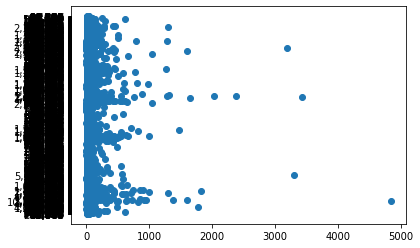

In [89]:
stores = groc_stores14['TOTAL']
pops = usda_pop['Population Estimate, 2016']
plt.scatter(stores[:-1],pops)

In [ ]:
g = sns.relplot(x="# of Stores", y="County Population",
                 col="variable", hue="results", style="results",
                 kind="line", data=grp_3,height=8, aspect=1.2,col_wrap=3)

plt.savefig('graphs/mobility_by_county_voting_history.png')